In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

from multisoc.generate.two_dimensional_population import consol_comp_pop_frac_tnsr,relative_correlation_inv

import fairness_simulations
from paper_plots import *

## Load simulation data and aggregate it

In [2]:
res_df1 = pd.read_csv("paper_results/2024_10_17_16_38_n_realiz_100_sym_h_N_500_all.gz",compression='gzip')
group_cols = [col for col in res_df1 if col.startswith("prm_")] + [col for col in res_df1 if col.startswith("mdl_pop")]
results_aggregated1 = fairness_simulations.aggr_repeated_simul(
	res_df1,
	aggr_fun_lst=[np.mean, np.std],
    group_cols = group_cols
	)

res_df2 = pd.read_csv("paper_results/2023_11_28_13_31_n_realiz_100_sym_h_N_500_all.gz",compression='gzip')
group_cols = [col for col in res_df2 if col.startswith("prm_")] + [col for col in res_df2 if col.startswith("mdl_pop")]
results_aggregated2 = fairness_simulations.aggr_repeated_simul(
	res_df2,
	aggr_fun_lst=[np.mean, np.std],
    group_cols = group_cols
	)

results_aggregated = pd.concat([results_aggregated1, results_aggregated2], axis=0)

## Plot inequalities

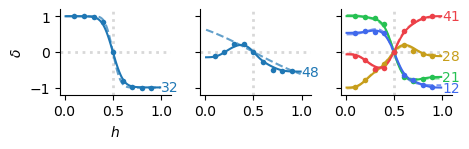

In [25]:
group_labels = [["m","M"],["m","M"]]
multidim_colors = np.array([["#25C152","#4069EC"],["#C79E1B","#EC4048"]])

## Model parameters
N = 500
f1m = 0.32
f2m = 0.48
corr_rs = 0.3
corr = relative_correlation_inv(f2m,corr_rs)

assert f1m <= f2m

## Plot analytic inequalities
fig, axs = plot_multidimensional_inequalities(N,f1m,f2m,corr,group_labels,multidim_colors,plot_only_minorities=True)

## Include simulations if they have been loaded and are stored in the results dataframe
try:
    plot_simulations_results(results_aggregated,axs,corr,f1m,f2m,multidim_colors,plot_only_minorities=True)
except NameError as e:
    if e.name == "results_aggregated":
        print ("WARNING! results_aggregated dataframe containing simulations is missing, showing only analytics")
    else:
        raise(e)

## To remove legend and get Figures with the same format as the paper
axs[0].legend('', frameon=False)
axs[2].legend('', frameon=False)

plt.tight_layout()
# plt.savefig(f"temp/inequalities_N{N}_f1m{int(100*f1m)}_f2m{int(100*f2m)}_k{int(100*corr)}.png",dpi=600)
plt.savefig(f"temp/inequalities_N{N}_f1m{int(100*f1m)}_f2m{int(100*f2m)}_k{int(100*corr)}_OnlyMin.pdf")
plt.savefig(f"temp/inequalities_N{N}_f1m{int(100*f1m)}_f2m{int(100*f2m)}_k{int(100*corr)}_OnlyMin.svg")
plt.show()

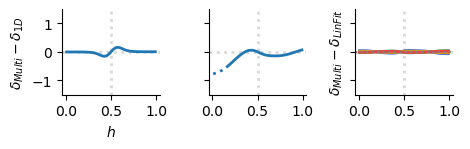

In [26]:
fig, axs = plot_multidimensional_inequalities_DIFFs(N,f1m,f2m,corr,group_labels,multidim_colors)

plt.tight_layout()
plt.savefig(f"temp/inequalities_N{N}_f1m{int(100*f1m)}_f2m{int(100*f2m)}_k{int(100*corr)}_DIFFs.pdf")
plt.savefig(f"temp/inequalities_N{N}_f1m{int(100*f1m)}_f2m{int(100*f2m)}_k{int(100*corr)}_DIFFs.svg")
plt.show()

In [13]:
def plot_multidimensional_inequalities_DIFFs(
    N,
    f1m,
    f2m,
    corr,
    group_labels = None,
    multidim_colors = None,
    axs = None
    ):

    ## Preliminaries
    N = int(N)
    assert f1m <= f2m
    marginal_distributions = [[f1m,1-f1m],[f2m,1-f2m]]

    ## All homophily values
    h_sym_lst = np.linspace(0.01,0.99,100)

    ## Multidimensional population distribution
    F = consol_comp_pop_frac_tnsr(marginal_distributions,corr)

    comp_indices = make_composite_index(F.shape)

    ## Compute deltas
    multidim_deltas_lst = {r:[] for r in comp_indices}

    onedim_deltas_hypothetical_lst = {
        d:{
            vi:[] 
            for vi in range(F.shape[d])
        } 
        for d in range(F.ndim)
    }
    
    onedim_deltas_lst = {
        d:{
            vi:[] 
            for vi in range(F.shape[d])
        } 
        for d in range(F.ndim)
    }

    ## Computations
    for h_sym in h_sym_lst:

        h_mtrx_lst = [
            np.array([
                [h_sym, 1-h_sym],
                [1-h_sym, h_sym]]),
            np.array([
                [h_sym, 1-h_sym],
                [1-h_sym, h_sym]])
                     ]

        H_theor = composite_H(
                h_mtrx_lst,
                "all",
                p_d = None,
                alpha = None,
                )

        multidim_deltas_i = analytical_1vRest_multidimensional_deltas(H_theor,F,N)
        onedim_deltas_i = analytical_1vRest_onedimensional_deltas(H_theor,F,N)
        for r, delta in multidim_deltas_i.items():
            multidim_deltas_lst[r].append(delta)
        for d in range(F.ndim):
            H_theor_1D = h_mtrx_lst[d]
            F_1D = np.array(marginal_distributions[d])
            onedim_deltas_hypothetical_i = analytical_1vRest_onedimensional_deltas(H_theor_1D,F_1D,N)
            for vi in range(F.shape[d]):
                onedim_deltas_lst[d][vi].append(onedim_deltas_i[d][vi])
                onedim_deltas_hypothetical_lst[d][vi].append(onedim_deltas_hypothetical_i[0][vi])

    ## Plot
    if axs is None:
        fig, axs = plt.subplots(1,3,figsize=(.4*4*3,.4*4))
    plt.sca(axs[-1])
#     for r, yplt in multidim_deltas_lst.items():
#         multidim_label = "".join(group_labels[d][r_d] for d,r_d in enumerate(r))
#         if multidim_colors is not None:
#             clr = multidim_colors[r]
#         else:
#             clr = None
#         p = plt.plot(h_sym_lst, yplt,"-",label=multidim_label,color=clr)
#         ## Label lines with group sizes
#         c = p[0].get_color()
#         lbl_str = int(np.ceil(100*F[r]))
# #             plt.plot(
# #                 1.05*h_sym_lst[-1],
# #                 yplt[-1],
# #                 marker=f"${lbl_str}$",
# #                 ms=30,
# #                 color=c
# #             )s
#         axs[-1].annotate(
#                 lbl_str,
#                 (
#                 #1.01,
#                 1.01*h_sym_lst[-1], 
#                 yplt[-1]),
#                 # xycoords=('axes fraction', 'data'), 
#                 xycoords=('data', 'data'), 
#                 color=c,
#                 va="center",
#                 ha="left")

#     plt.legend(bbox_to_anchor=(0.05, 1.05),loc="lower left")
    plt.axvline(0.5,color="grey",alpha=0.3,lw=2,ls=":",zorder=0)
    plt.axhline(0,color="grey",alpha=0.3,lw=2,ls=":",zorder=0)
# #     plt.xlabel("$h$")
#     plt.ylim(-1.2,1.2)
#     plt.xlim(-.05,1.1)


    axs[1].sharey(axs[0])
    for d in range(F.ndim):
#         plt.figure()
        plt.sca(axs[d])
        
        yplt = np.array(onedim_deltas_lst[d][0])
        yplt_hypo = np.array(onedim_deltas_hypothetical_lst[d][0])

        if d == 0:
            plt.xlabel("$h$")
            plt.ylabel(r"$\delta_{Multi} - \delta_{1D}$")

        plot_line_segments(h_sym_lst,
                           yplt-yplt_hypo,
                           yplt*yplt_hypo,
                           ax=axs[d],
                           color="C0")
        
        if d != 0:
            plt.setp( axs[d].get_yticklabels(), visible=False)

        plt.axvline(0.5,color="grey",alpha=0.3,lw=2,ls=":",zorder=0)
        plt.axhline(0,color="grey",alpha=0.3,lw=2,ls=":",zorder=0)
        plt.ylim(-1.5,1.5)
        # plt.xlim(-.05,1.1)
        plt.xticks([0,0.5,1])
        # axs[d].set_yscale('symlog', linthresh=0.1, base=2)
        # axs[d].yaxis.set_major_locator(ticker.SymmetricalLogLocator(base=2, linthresh=0.01, subs=[8]))
        plt.gca().spines.right.set_visible(False)
        plt.gca().spines.top.set_visible(False)

    for i, (r, yy) in enumerate(multidim_deltas_lst.items()):
        xx_lst = []
        for d, vi in enumerate(r):
            xx = onedim_deltas_lst[d][vi]
            xx_lst.append(xx)

        clf = linear_model.LinearRegression()
        X = np.array(xx_lst)
        reg = clf.fit(X.T, yy)

#         plt.figure("all_multidimensional")
        plt.sca(axs[-1])
        if multidim_colors is not None:
            clr = multidim_colors[r]
        else:
            clr = f"C{i}"

        yy_linfit_diff = yy-( reg.coef_[0]*X[0] + reg.coef_[1]*X[1] + reg.intercept_)
        yy_linfit_sign = yy*( reg.coef_[0]*X[0] + reg.coef_[1]*X[1] + reg.intercept_)
        plot_line_segments(h_sym_lst,yy_linfit_diff,yy_linfit_sign,axs[-1],clr)
        # plt.plot(h_sym_lst, yy-( reg.coef_[0]*X[0] + reg.coef_[1]*X[1] + reg.intercept_),"-",color=clr,alpha=0.7,zorder=1)
        plt.setp( axs[-1].get_yticklabels(), visible=False)
        plt.xticks([0,0.5,1])
        plt.gca().spines.top.set_visible(False)
        plt.gca().spines.right.set_visible(False)
    # axs[-1].set_yscale('symlog', linthresh=0.1, base=2)
    axs[-1].set_ylim(-1.5,1.5)
    axs[-1].axhline(0,color="grey",ls=":")
    axs[-1].set_ylabel(r"$\delta_{Multi} - \delta_{LinFit}$")
    
    return fig, axs

def plot_line_segments(x,y,signs,ax,color):
    plt.sca(ax)
    # Find sign changes
    sign_changes = np.where(np.sign((signs)[:-1]) != np.sign((signs)[1:]))[0]

    if len(sign_changes) > 0:
        # Start from the first point
        start_idx = 0
        
        # Loop over sign change points
        for idx in sign_changes:
            end_idx = idx  # Include the crossing point
            
            # Select the segment
            x_seg = x[start_idx:end_idx]
            y_seg = y[start_idx:end_idx]
            
            # Choose linestyle based on the sign of the first point in the segment
            linestyle = '-' if (signs)[start_idx+1] > 0 else ':'
            
            # Plot the segment
            plt.plot(x_seg, y_seg, linestyle=linestyle, color=color,lw=2)
            
            # Move start index to the next segment
            start_idx = end_idx
        
        # Plot the last segment
        x_seg = x[start_idx-1:]
        y_seg = y[start_idx-1:]
        linestyle = '-' if (signs)[start_idx+1] > 0 else ':'
        plt.plot(x_seg, y_seg, linestyle=linestyle, color=color,lw=2)

    else:
        linestyle = '-' if signs[5] > 0 else ':'
        plt.plot(x, y, color=color,lw=2, ls=linestyle)